# Bonus Deep Learning Project 2

In [1]:
import numpy as np
import struct
import gzip
import urllib.request
import os

In [2]:
def download_mnist(path='mnist'):
    os.makedirs(path, exist_ok=True)
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
    files = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz"
    }
    
    for key, filename in files.items():
        filepath = os.path.join(path, filename)
        
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(base_url + filename, filepath)
            
    print("MNIST dataset downloaded.")

def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
        images = images.astype(np.float32) / 255.0  # Normalize to [0,1]
        return images

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

def load_mnist(path='mnist'):
    download_mnist(path)
    train_images = load_mnist_images(os.path.join(path, "train-images-idx3-ubyte.gz"))
    train_labels = load_mnist_labels(os.path.join(path, "train-labels-idx1-ubyte.gz"))
    test_images = load_mnist_images(os.path.join(path, "t10k-images-idx3-ubyte.gz"))
    test_labels = load_mnist_labels(os.path.join(path, "t10k-labels-idx1-ubyte.gz"))
    return train_images, train_labels, test_images, test_labels

In [3]:
# Load MNIST training images (for speed, we use a small subset)
train_images, train_labels, test_images, test_labels = load_mnist()

MNIST dataset downloaded.


# Core Layer Classes

In [4]:
class FullyConnected:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * 0.05
        self.b = np.zeros((1, out_dim))

    def forward(self, x):
        self.x = x
        self.z = x @ self.W + self.b  
        
        return self.z 

    def backward(self, grad, lr):
        m = grad.shape[0]
        
        # Calculate gradients
        dW = self.x.T.dot(grad) / m
        db = np.sum(grad, axis = 0, keepdims = True) / m
        dx = grad.dot(self.W.T)

        # Gradient updates
        self.W -= lr * dW
        self.b -= lr * db

        return dx

In [5]:
class Conv2D:
    def __init__(self, in_ch, out_ch, k, stride = 1, pad = 0):
        self.stride = stride
        self.pad = pad
        self.W = np.random.randn(out_ch, in_ch, k, k) * 0.05
        self.b = np.zeros((out_ch,))
        

    def forward(self, x):
        N, C, H, width = x.shape
        F, _, k, _ = self.W.shape

        h_out = ((H + (2 * self.pad) - k) // self.stride) + 1
        w_out = ((width + (2 * self.pad) - k) // self.stride) + 1

        # Now we pad x
        x_padded = np.pad(
                x,
                pad_width=((0,0), (0,0), (self.pad,self.pad), (self.pad,self.pad)),
                mode='constant',
                constant_values=0
            )

        out = np.zeros((N, self.W.shape[0], h_out, w_out), dtype = x.dtype)

        for m in range(N):
            for n in range(F):
                for i in range(h_out):
                    for j in range(w_out):
                        vertical = i * self.stride
                        horizontal = j * self.stride

                        area = x_padded[m, :, vertical : vertical + k, horizontal : horizontal + k]
                        out[m, n, i, j] = np.sum(area * self.W[n]) + self.b[n]

        self.x_padded = x_padded
        self.x_shape = x.shape
                        
        return out
                

    def backward(self, grad, lr):
        N, C, H_pad, W_pad = self.x_padded.shape
        x_padded = self.x_padded
        F, _, k, _ = self.W.shape 
        _, _, h_out, w_out = grad.shape

        # Initializing gradients
        dW = np.zeros_like(self.W)           
        db = np.zeros_like(self.b)         
        dx_padded = np.zeros_like(x_padded) 

        for m in range(N):
            for n in range(F):
                for i in range(h_out):
                    for j in range(w_out):
                        vert_start = i * self.stride
                        horiz_start = j * self.stride

                        area = x_padded[m, :, vert_start:vert_start + k, horiz_start:horiz_start + k]
                        dW[n] += grad[m, n, i, j] * area
                        db[n] += grad[m, n, i, j]

                        dx_padded[m, :, vert_start:vert_start + k, horiz_start:horiz_start + k] += grad[m, n, i, j] * self.W[n]
                        
        # Unpad
        if self.pad>0:
            dx = dx_padded[:,:,self.pad:-self.pad,self.pad:-self.pad]
        else:
            dx = dx_padded
            
        # Update Gradients
        self.W -= lr * dW
        self.b -= lr * db
        return dx

In [6]:
class MaxPool2D:
    def __init__(self, k, stride = 1, pad = 0):
        self.k = k
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, width = x.shape
        k = self.k

        h_out = ((H + 2*self.pad - k) // self.stride) + 1
        w_out = ((width + 2*self.pad - k) // self.stride) + 1

        # Pad Input
        x_padded = np.pad(
            x,
            pad_width=((0,0), (0,0), (self.pad,self.pad), (self.pad,self.pad)),
            mode='constant',
            constant_values = 0
        )

        out = np.zeros((N, C, h_out, w_out), dtype = x.dtype)

        for m in range(N):
            for c in range(C):
                for i in range(h_out):
                    for j in range(w_out):
                        vert_start = i * self.stride
                        horiz_start = j * self.stride

                        region = x_padded[m, c, vert_start:vert_start+k, horiz_start:horiz_start+k]
                        out[m, c, i, j] = np.max(region)

        self.x_padded = x_padded
        self.x_shape = x.shape

        return out

    def backward(self, grad):
        N, C, H_pad, W_pad = self.x_padded.shape
        k = self.k
        _, _, h_out, w_out = grad.shape

        dx_padded = np.zeros_like(self.x_padded)

        for m in range(N):
            for c in range(C):
                for i in range(h_out):
                    for j in range(w_out):
                        vert_start = i * self.stride
                        horiz_start = j * self.stride

                        region = self.x_padded[m, c, vert_start:vert_start+k, horiz_start:horiz_start+k]
                        max_val = np.max(region)
                        mask = (region == max_val)

                        dx_padded[m, c, vert_start:vert_start+k, horiz_start:horiz_start+k] += mask * grad[m, c, i, j]

        # unpad
        if self.pad > 0:
            dx = dx_padded[:, :, self.pad:-self.pad, self.pad:-self.pad]
        else:
            dx = dx_padded

        return dx

In [7]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.9):
        self.gamma = np.ones((1, dim))
        self.beta  = np.zeros((1, dim))
        self.running_mean = np.zeros((1, dim))
        self.running_var  = np.ones((1, dim))
        self.eps = eps
        self.momentum = momentum

    def forward(self, x, train = True):
        if train:
            mu = x.mean(axis = 0, keepdims = True)
            var = x.var(axis = 0, keepdims = True)                   
            self.x_centered = x - mu
            self.std_inv = 1.0 / np.sqrt(var + self.eps)

            x_norm = self.x_centered * self.std_inv              
            out = self.gamma * x_norm + self.beta

            # Update running stats
            self.running_mean = (self.momentum * self.running_mean + (1-self.momentum)*mu)
            self.running_var  = (self.momentum * self.running_var  + (1-self.momentum)*var)
            self.x_norm = x_norm
        else:
            x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            out = self.gamma * x_norm + self.beta

        return out

    def backward(self, grad_out, lr):
        N, D = grad_out.shape

        # Find gradients
        dgamma = np.sum(grad_out * self.x_norm, axis=0, keepdims=True)
        dbeta  = np.sum(grad_out, axis=0, keepdims=True)

        # Propagate into x_norm
        dx_norm = grad_out * self.gamma                         
        dvar = np.sum(dx_norm * self.x_centered * -0.5 *(self.std_inv**3), axis=0, keepdims=True)
        dmu  = np.sum(-dx_norm * self.std_inv, axis=0, keepdims=True) + dvar * np.mean(-2.0 * self.x_centered, axis=0, keepdims=True)
        dx = (dx_norm * self.std_inv) + (dvar * 2 * self.x_centered / N) + (dmu / N)

        # Parameter update
        self.gamma -= lr * dgamma
        self.beta  -= lr * dbeta

        return dx


# Activation Functions & Their Derivatives

In [8]:
def sigmoid(x): 
    return 1/(1+np.exp(-x))
    
def sigmoid_deriv(x):
    s = sigmoid(x)
    return s*(1-s)

In [9]:
def lrelu(x, α = 0.2): 
    return np.maximum(x, α*x)
    
def lrelu_deriv(x, α=0.2): 
    return (x>0).astype(float) + α*(x<=0).astype(float)

In [10]:
def tanh(x): 
    return np.tanh(x)
    
def tanh_deriv(x): 
    return 1 - np.tanh(x)**2

# Generator 

In [11]:
class Generator:
    def __init__(self, dim_z):
        self.fc1 = FullyConnected(dim_z, 256)
        self.bn1  = BatchNorm1d(256)
        self.fc2 = FullyConnected(256, 512)
        self.bn2  = BatchNorm1d(512)
        self.fc3 = FullyConnected(512, 1024)
        self.bn3  = BatchNorm1d(1024)
        self.fc4 = FullyConnected(1024, 784) # 784 = 28*28 -> Dimension of MNIST images 

    def forward(self, z):
        x = self.fc1.forward(z)
        x = self.bn1.forward(x, train = True)
        self.h1 = x               
        x = lrelu(self.h1)

        x = self.fc2.forward(x)
        x = self.bn2.forward(x, train = True)
        self.h2 = x               
        x = lrelu(self.h2)

        x = self.fc3.forward(x)
        x = self.bn3.forward(x, train = True)
        self.h3 = x               
        x = lrelu(self.h3)

        x = tanh(self.fc4.forward(x))
        return x.reshape(-1,1,28,28)

    def backward(self, grad_img, lr):
        batch_size = grad_img.shape[0]
        grad = grad_img.reshape(batch_size, 784)

        d_tanh = tanh_deriv(self.fc4.z)      
        grad = grad * d_tanh                 
        grad = self.fc4.backward(grad, lr)    

        d_relu3 = lrelu_deriv(self.h3)
        grad   *= d_relu3
        grad    = self.bn3.backward(grad, lr)
        grad    = self.fc3.backward(grad, lr)

        d_relu2 = lrelu_deriv(self.h2)
        grad   *= d_relu2
        grad    = self.bn2.backward(grad, lr)
        grad    = self.fc2.backward(grad, lr)
        
        d_relu1 = lrelu_deriv(self.h1)
        grad   *= d_relu1
        grad    = self.bn1.backward(grad, lr)
        _       = self.fc1.backward(grad, lr)

# Discriminator

In [12]:
class Discriminator:
    def __init__(self):
        self.fc1 = FullyConnected(784, 1024)
        self.bn1  = BatchNorm1d(1024)
        self.fc2 = FullyConnected(1024, 512)
        self.bn2  = BatchNorm1d(512)
        self.fc3 = FullyConnected(512, 256)
        self.bn3  = BatchNorm1d(256)
        self.fc4 = FullyConnected(256, 1)

    def forward(self, img):
        x = img.reshape(img.shape[0], -1)

        x = self.fc1.forward(x)
        x = self.bn1.forward(x, train=True)
        self.h1 = x                 
        x = lrelu(self.h1)

        x = self.fc2.forward(x)
        x = self.bn2.forward(x, train=True)
        self.h2 = x                 
        x = lrelu(self.h2)

        x = self.fc3.forward(x)
        x = self.bn3.forward(x, train=True)
        self.h3 = x                 
        x = lrelu(self.h3)

        logit = self.fc4.forward(x)
        
        return sigmoid(logit)

    def backward(self, upstream_grad, lr, update = True):
        ds = sigmoid_deriv(self.fc4.z)
        g  = upstream_grad * ds
        g  = self.fc4.backward(g, lr if update else 0)

        dr3 = lrelu_deriv(self.h3)
        g   = g * dr3
        g   = self.bn3.backward(g, lr if update else 0)
        g   = self.fc3.backward(g, lr if update else 0)

        dr2 = lrelu_deriv(self.h2)
        g   = g * dr2
        g   = self.bn2.backward(g, lr if update else 0)
        g   = self.fc2.backward(g, lr if update else 0)

        dr1 = lrelu_deriv(self.h1)
        g   = g * dr1
        g   = self.bn1.backward(g, lr if update else 0)
        dx  = self.fc1.backward(g, lr if update else 0)
        
        return dx

# Training Loop

In [13]:
# Binary Cross-Entropy Loss Function
def bce_loss(y_pred, y_true):
    eps = 1e-8
    return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

In [14]:
def train(gen, disc, images, epochs = 50, batch_size = 64, lr_d = 1e-5, lr_g = 1e-5, dim_z = 100):
    n = images.shape[0]
    
    # Histories
    d_real_loss = []
    d_fake_loss = []
    g_loss_hist = []
    d_real_acc = []
    d_fake_acc = []

    for epoch in range(epochs):
        perm = np.random.permutation(n)
        for i in range(0, n, batch_size):
            idx = perm[i : i + batch_size]
            real = images[idx][:, None, :, :]

            # Now we train D on real and fake images
            z = np.random.randn(len(idx), dim_z)
            fake = gen.forward(z)

            d_out_real = disc.forward(real)
            d_out_fake = disc.forward(fake)

            # Losses
            loss_real = bce_loss(d_out_real, 0.9 * np.ones_like(d_out_real))
            loss_fake = bce_loss(d_out_fake, np.zeros_like(d_out_fake))
            d_loss    = loss_real + loss_fake

            # Accuracies
            ar = np.mean(d_out_real > 0.5)
            af = np.mean(d_out_fake < 0.5)

            grad_real = -(1 / (d_out_real + 1e-8))
            grad_fake =  (1 / (1 - d_out_fake + 1e-8))

            # only update D if it’s not already too confused
            if d_loss < 1.0:
                disc.backward(grad_real, lr_d, update=True)
                disc.backward(grad_fake, lr_d, update=True)

            # Now we train the generator by fooling the discriminator
            z2 = np.random.randn(len(idx), dim_z)
            fake2 = gen.forward(z2)
            d_out2 = disc.forward(fake2)

            lg = bce_loss(d_out2, 0.9 * np.ones_like(d_out2))
            grad_g = -(1 / (d_out2 + 1e-8))

            # Backpropogate D followed by G
            dx = disc.backward(grad_g, 0, update=False) # The discriminator is frozen here -> D's parameters stay fixed

            # Chain through D's sigmoid 
            gen.backward(dx, lr_g)

            # Now we store all the values for plotting
            d_real_loss.append(loss_real)
            d_fake_loss.append(loss_fake)
            g_loss_hist.append(lg)
            d_real_acc.append(ar)
            d_fake_acc.append(af)

        print(f"Epoch {epoch+1}/{epochs}  "
              f"D(real)={loss_real:.3f}  D(fake)={loss_fake:.3f}  G={lg:.3f}")


    # Losses
    plt.figure(figsize=(8,4))
    plt.plot(d_real_loss, label='D Real')
    plt.plot(d_fake_loss, label='D Fake')
    plt.plot(g_loss_hist,  label='G Loss')
    plt.title('GAN Losses')
    plt.xlabel('Batch')
    plt.legend()
    plt.show()

    # Accuracies
    plt.figure(figsize=(8,4))
    plt.plot(d_real_acc, label='D Acc on Real')
    plt.plot(d_fake_acc, label='D Acc on Fake')
    plt.title('Discriminator Accuracy')
    plt.xlabel('Batch')
    plt.legend()
    plt.show()
                        

# Main

Epoch 1/500  D(real)=0.740  D(fake)=0.681  G=0.747
Epoch 2/500  D(real)=0.747  D(fake)=0.707  G=0.740
Epoch 3/500  D(real)=0.742  D(fake)=0.693  G=0.743
Epoch 4/500  D(real)=0.770  D(fake)=0.668  G=0.738
Epoch 5/500  D(real)=0.739  D(fake)=0.680  G=0.749
Epoch 6/500  D(real)=0.744  D(fake)=0.673  G=0.747
Epoch 7/500  D(real)=0.771  D(fake)=0.680  G=0.750
Epoch 8/500  D(real)=0.755  D(fake)=0.689  G=0.736
Epoch 9/500  D(real)=0.749  D(fake)=0.673  G=0.741
Epoch 10/500  D(real)=0.755  D(fake)=0.672  G=0.734
Epoch 11/500  D(real)=0.762  D(fake)=0.674  G=0.740
Epoch 12/500  D(real)=0.747  D(fake)=0.668  G=0.755
Epoch 13/500  D(real)=0.740  D(fake)=0.680  G=0.739
Epoch 14/500  D(real)=0.754  D(fake)=0.685  G=0.745
Epoch 15/500  D(real)=0.753  D(fake)=0.680  G=0.733
Epoch 16/500  D(real)=0.756  D(fake)=0.676  G=0.747
Epoch 17/500  D(real)=0.755  D(fake)=0.667  G=0.756
Epoch 18/500  D(real)=0.747  D(fake)=0.671  G=0.744
Epoch 19/500  D(real)=0.761  D(fake)=0.668  G=0.742
Epoch 20/500  D(real)

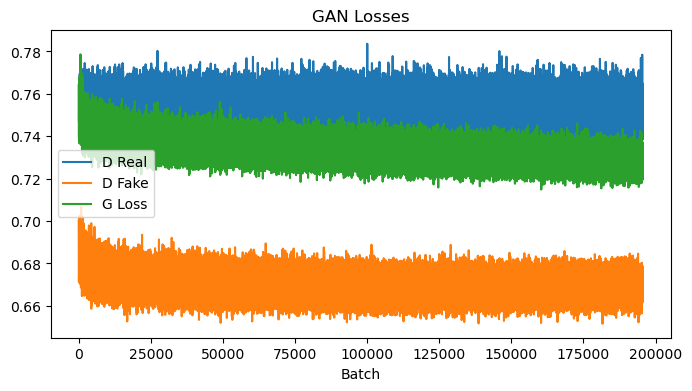

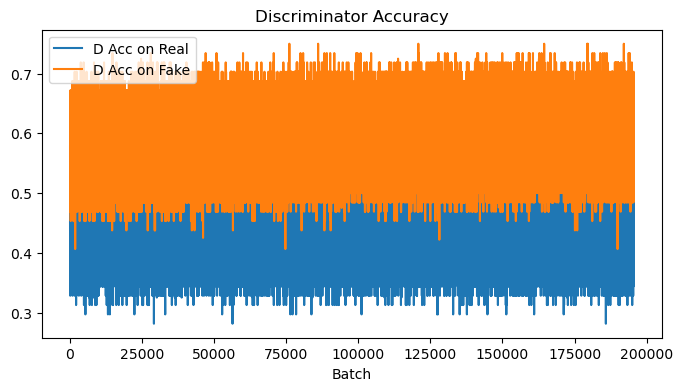

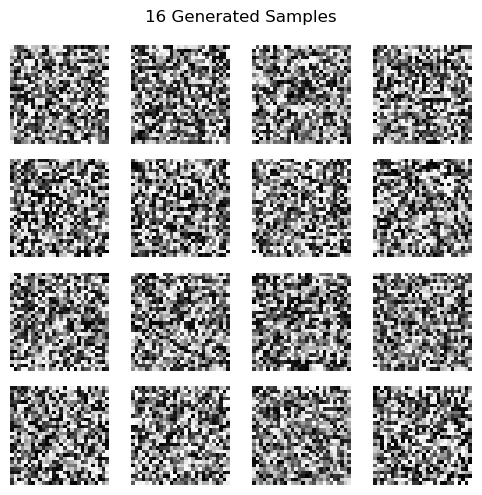

In [15]:
import matplotlib.pyplot as plt

# Initiating the GAN
dim_z = 100
gen  = Generator(dim_z)
disc = Discriminator()

subset = 25_000                 
train_images  = train_images[:subset]
train_labels  = train_labels[:subset]

train(
    gen, 
    disc, 
    train_images, 
    epochs     = 500, 
    batch_size = 64, 
    lr_d       = 3e-4, 
    lr_g       = 4e-4,
    dim_z      = dim_z
)

# After training the generator, we sample 16 random new z's and plot them
n_samples = 16
z = np.random.randn(n_samples, dim_z)
fake_images = gen.forward(z)

fig, axes = plt.subplots(4, 4, figsize=(5,5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i,0], cmap='gray')
    ax.axis('off')
    
plt.suptitle("16 Generated Samples")
plt.tight_layout()
plt.show()